2018 Edition

# Building a music recommender system
<div class="alert alert-block alert-success">
<p>Thomas Marchand</p>
<p>Spark : v$2.2.0$</p>
<p>Python : $3.6.4$</p>
</div>



As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

## Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm (serial and parallel versions)

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

## Steps

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Spark SQL, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing a (parallel) algorithm
* Finally, we will focus on an existing implementation, available in the Apache Spark MLLib, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.


# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for “scrobbling”, or recording listeners’ plays of artists’ songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists’ are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [101]:
import os
import sys
import re
import random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *


%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time
import seaborn as sns
sns.set()

sqlContext = SQLContext(sc)
base = "/datasets/lastfm/"

### Question 1

#### Question 1.0 (Non-grading)
<div class="alert alert-info">
Using SPARK SQL, load data from `/datasets/lastfm/user_artist_data.txt` and show the first 20 entries (via function `show()`).
</div>

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".

In [103]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()
userArtistDF.printSchema()
userArtistDF.show(5)

root
 |-- userID: long (nullable = true)
 |-- artistID: long (nullable = true)
 |-- playCount: integer (nullable = true)

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows



### Comments

<div class="alert alert-success">

We've just built a DataFrame. It is a structure of higher level compared to RDD with a schema that allows SparkSQL to do optimizatons. It is therefore useful when we do analytics.
</div>

#### Question 1.1: 
<div class="alert alert-info">
How many distinct users do we have in our data? 
</div>

In [104]:
uniqueUsers = userArtistDF.select('userID')\
    .distinct()\
    .count()
    
print("Total n. of users: ", uniqueUsers)

Total n. of users:  148111


#### Question 1.2
<div class="alert alert-info">
How many distinct artists do we have in our data ?
</div>

In [105]:
uniqueArtists = userArtistDF.select('artistID')\
    .distinct()\
    .count()
    
print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1631028


### Comments

<div class="alert alert-success">

In our case, users are users and artists are items. We see that there is a lot more items than users which is not a problem because it should not be a surprise if some artists have no or little audience.
</div>

#### Question 1.3
<div class="alert alert-info">
One limitation of Spark MLlib's ALS implementation - which we will use later - is that it requires IDs for users and items to be nonnegative 32-bit integers. This means that IDs larger than `Integer.MAX_VALUE`, or `2147483647`, can't be used. So we need to check whether this data set conforms to the strict requirements of our library.  

What are the maximum and minimum values of column `userID` ?  
</div>

### Comments

<div class="alert alert-success">

**see below**
</div>

#### Question 1.4
<div class="alert alert-info">
What is the maximum and minimum values of column `artistID` ?
</div>

In [106]:
userArtistDF.describe()\
    .show()

+-------+------------------+------------------+-----------------+
|summary|            userID|          artistID|        playCount|
+-------+------------------+------------------+-----------------+
|  count|          24296858|          24296858|         24296858|
|   mean|1947573.2653533637|1718704.0937568964|15.29576248089362|
| stddev| 496000.5551819132| 2539389.092428355|153.9153244697963|
|    min|                90|                 1|                1|
|    max|           2443548|          10794401|           439771|
+-------+------------------+------------------+-----------------+



### Comments

<div class="alert alert-success">
`.describe()` permits us to have a nice overview of the spectrum of used values. We see that both `userID` & `artistID`'s  `min` and `max` values are smaller that `Integer.MAX_VALUE`, or `2147483647`. We can use MLib freely.
</div>

We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. The maximum values of `userID` and `artistID` are still smaller than the biggest number of integer type.  No additional transformation will be necessary to use these IDs.

One thing we can see here is that SPARK SQL provides very concise and powerful methods for data analytics (compared to using RDD and their low-level API). You can see more examples [here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).

Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
<div class="alert alert-info">
How many times each user has played a song? Show 5 samples of the result.
</div>

+-------+--------------+
| userID|sum(playCount)|
+-------+--------------+
|1000061|           244|
|1000070|         20200|
|1000313|           201|
|1000832|          1064|
|1000905|           214|
+-------+--------------+



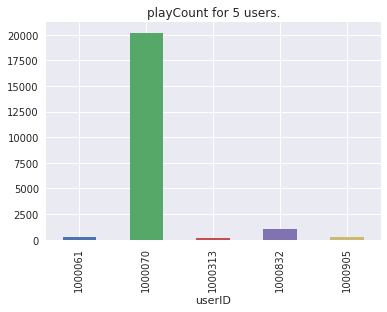

In [129]:
userActivity = userArtistDF.groupBy('userID').sum('playCount')
userActivity5 = userActivity.limit(5)
userActivity5.show()
userActivityPD = userActivity5.toPandas();
userActivityPD.plot(x='userID', y = 'sum(playCount)', kind='bar', legend=False, title='playCount for 5 users.');

### Comments

<div class="alert alert-success">
From the graph we see that the number of played song can very a lot from user to user. Our system will have to be able to recommend very active users but also very inactive users. With this in mind we can look up the percentage of the total activity that is done by the Top users in term of song played. We are going to look to impact of the top 0.1% users.
</div>

    userID  sum(playCount)
0  1059637          674412
1  2064012          548427
2  2069337          393515
3  2023977          285978
4  1046559          183972
number of listenings:


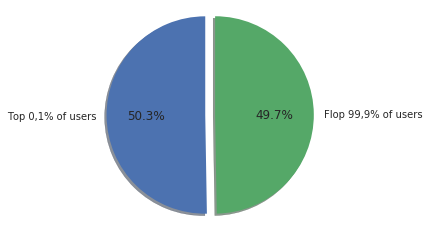

In [108]:
firstTenthPercent = uniqueUsers//1000 
totalActivity = 24296858
userActivityFristTenthPercentPD = userActivity\
    .orderBy('sum(playCount)', ascending=0)\
    .limit(firstTenthPercent)\
    .toPandas() # this Pandas' DataFrame has the top 0.1% users and their number of song played
    
print(userActivityFristTenthPercentPD.head())
    
userActivityFristTenthPercent = userActivityFristTenthPercentPD.sum(axis = 0)[1] # we extract the sum of the song played
activityFristTenthPercent = userActivityFristTenthPercent/totalActivity*100 # we compute the percentage

# standard Pie chart
labels = 'Top 0,1% of users', 'Flop 99,9% of users'
sizes = [activityFristTenthPercent, 100 - activityFristTenthPercent]
explode = (0.1, 0)  # only "explode" the first slide


print('number of listenings:')
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Comments

<div class="alert alert-success">
As previously taught we see that the 0,1% most active users account for more than the 99,9% others. The data is highly unbalanced. For instance the 5 most active users have played more songs than humanly possible. Maybe those accounts were shared among multiple users, or maybe they are bots or it is simply poor quality data.

In the futur we might considere excluding this data. It would greatly reduce our dataset, which is a shame, but this data is not close to reality at least at first glance.</div>

#### Question 2.2
<div class="alert alert-info">
Plot CDF (or ECDF) of the number of play counts per User ID.  

Explain and comment the figure you just created:   
<ul>
<li>for example, look at important percentiles (25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible. </li>
<li>discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system. </li>
<li>look at outliers and reason about their impact on your reccommender algorithm</li>
</ul>
</div>

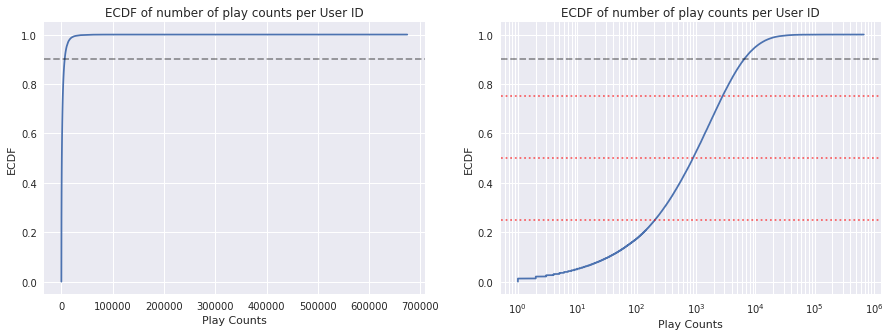

In [109]:
UA = userActivity.collect()
pdf = pd.DataFrame(data=UA)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

plt.figure(figsize=(15,5))

#left graph
plt.subplot(121)
plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID');
plt.axhline(y=0.9, linestyle="--", color ='black', alpha=0.4)

#right graph
plt.subplot(122)
plt.semilogx( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID');
plt.axhline(y=0.25, linestyle=":", color ='r',alpha=0.6)
plt.axhline(y=0.5, linestyle=":", color ='r',alpha=0.6)
plt.axhline(y=0.75, linestyle=":", color ='r',alpha=0.6)
plt.axhline(y=0.9, linestyle="--", color ='black',alpha=0.4);


|Percentile |Play Counts|
|:-----------:|:---------:|
|25%        |200|
|50%        |800|
|75%        |3000|
|90%        |6500|



### Comments

<div class="alert alert-success">
<ul>
<li>Right above are displayed the ECDF graph of number of play counts per User ID with standard axis(left) and with a log scale for the y-axis only(right). The difference between ECDF and CDF resides in the fact that the ECDF is normalized, this is why our graph tends towards 1 when the play counts tends towards infinity. </li>

<li>The ECDF graph represents the fraction of users per number of song played. The standard graph is not very convincing,  it is difficult to read. This is where the semilog graph comes in handy. </li>

<li>We can see that very few users are beyond $10^4$ song played with seems legit. With the semilog one, we can see that the few users that are beyond $10^4$ can go as far as $6.10^5$ which is a really big number. I would probably choose like  $5.10^4$ as a limit if it was needed to exclude outliers.</li>
<li>As discussed at the previous comment-block, those few outliers have a big impact on our recommender system because they will have a big weight when it comes to the matrix factorisation because some $r_{ui}$ are going to be huge and will force some terms of $X$ and $Y$ to be big aswell.</li>
<li>Since of system is music recommendation and aims at being scalable and expendable to a bunch of new users, it may be smart to exclude the outliers for "the greater good". Giving recommendation to people who already listened 50 000 songs is difficult because they know what they like and probably master their favorite music domain more than anybody else. Their weight is so big that it might affect the whole recommendaton algorithm.</li>
<li>Similarly it is difficult to recommend music to someone with little past activity. The remedy would be to recommend famous artist that do similar music to the little they have listen to. Some flagship artists would be useful here.(Eminem for US rap, Nirvana for Metal, The Beatles for Pop Rock, Bob Marley for Reggae...). Unfortunatly we have zero information about the items so this strategy is not posible with our dataset. </li>
<li>The good news is that a good chunk of our users are listening to between 100 and 6000 songs which are good numbers(realistic & useful).</li>
</ul>

</div>

#### Question 2.3

<div class="alert alert-info">
How many play counts for each artist? Plot CDF or ECDF of the result.  

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?
</div>

+--------+---+
|artistID|  s|
+--------+---+
+--------+---+



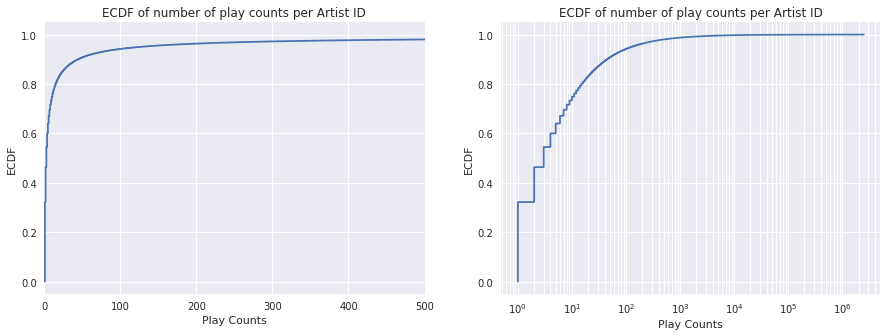

In [110]:
artistPopularity = userArtistDF.groupBy('artistID').sum('playCount')
artistPopularity5 = artistPopularity.limit(5)
#just checking that no artist is useless
artistPopularity5.withColumnRenamed('sum(playCount)', 's').filter("s < 1").show()

AP = artistPopularity.collect()
pdf2 = pd.DataFrame(data=AP)
Y=np.sort(pdf2[1])
yvals=np.arange(len(Y))/float(len(Y))

plt.figure(figsize=(15,5))

#left graph
plt.subplot(121)
plt.plot( Y, yvals )
plt.xlabel('Play Counts')
plt.xlim(xmin=0,xmax=500)
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per Artist ID');

#right graph
plt.subplot(122)
plt.semilogx( Y, yvals )
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per Artist ID');

### Comments

<div class="alert alert-success">
<ul>
<li>Right above are displayed the ECDF graph of number of play counts per Artist ID with standard axis(left) and with a log scale for the y-axis only(right).</li>
<li>As previously mentionned at beginning of the Notebook,the high number of artist(>1M) forshadowed the fact most of them won't have much audience. About 75% of the artists have less than 10 listenings which is very little.</li>
<li>This is bad because our algorithm is based on `Collaborative-Filtering` so the only information that we have on an artist are the listenings so if an artist has few of those we basically know nothing about him.</li>
<li>None of them are 'useless' because all of them have at least 1 listening. One can argue that an artist with only one listening is near useless because it is going to be difficult to draw comparaisons from it since his audience is limited to one. Yet we can still recommand it so we might aswell keep them.</li>
<li>Only 20% of the artist have more than 15 play counts. And around 50%(~0.8M) have 1 or 2 listenings. The data is quite dirty, after cleaning this will be slightly better. </li>
<li>As mentionned in the comments of the provided code, grouping bu `artistID` is problematic but we will clean the artist dataset later in the notebook. Yet we can say that the data is of poor quality until we clean it a bit therefore those graph are giving us a general overview of the data but no detailed insights. </li>
</ul>

</div>

#### Question 2.4
<div class="alert alert-info">
Plot a bar chart to show top 5 artists In terms of absolute play counts.  

Comment the figure you just obtained: 
<ul>
<li>are these reasonable results?</li>
<li>is looking at top-5 artists enough to learn more about your data?</li>
<li>do you see anything strange in the data?</li>
</ul>
</div>

```python
sortedArtist = sorted(artistPopularity, key = lambda x: -x[...])[: ...]

artistID = [w[...] for w in sortedArtist]

y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]

plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()
```

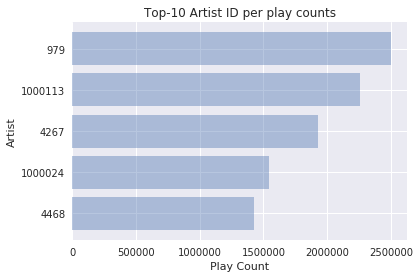

In [111]:
sortedArtist = sorted(AP, key = lambda x: -x[1])[:5] #we can reuse the last .collect()

artistID = [w[0] for w in sortedArtist]

y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]

plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()

### Comments

<div class="alert alert-success">
<ul>
<li>Right above are displayed the ECDF graph of number of play counts per Artist ID with standard axis(left) and with a log scale for the y-axis only(right).</li>
<li>Unfortunatly we don't have the names yet. But we can wonder that those artist are pretty famous. The fact that the first one does roughly 1% of all the song played is not realistic.</li>
<li>Those huge values contrast heavily with the million of artist with barely 3 listenings. </li>
<li>It is difficult to have true insights with only the Top5 artists in term of play counts. So far nothing is strange apart from the fact that the most listened artist has more listening than the cumulative sum of the 0.8M least listened artists. </li>
</ul>

</div>

All seems clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1

<div class="alert alert-info">
Load the data from `/datasets/lastfm/artist_data.txt` and use the SparkSQL API to show 5 samples.  

<ul></ul>
<div class="label label-success">HINT:</div> If you encounter some error when parsing lines in data because of invalid entries, parameter `mode='DROPMALFORMED'` will help you to eliminate these entries. The suggested syntax is: `<df>.options(header='false', delimiter='\t', mode='DROPMALFORMED')`.

</div>

In [112]:
#For Google Cloud use:
#    .load("gs://dataproc-c4038cbd-7c98-485e-9ad2-fb5c00265b6a-eu/notebooks/artist_data.txt", schema = customSchemaArtist) \


customSchemaArtist = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("name", StringType(), True)])

artistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + "artist_data.txt", schema = customSchemaArtist) \
    .cache() #we cache it because we will use it a lot


artistDF.show(5)

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
| 1134999|        06Crazy Life|
| 6821360|        Pang Nakarin|
|10113088|Terfel, Bartoli- ...|
|10151459| The Flaming Sidebur|
| 6826647|   Bodenstandig 3000|
+--------+--------------------+
only showing top 5 rows



#### Question 3.2
<div class="alert alert-info">
Find 20 artists whose name contains `Aerosmith`. Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?  

<ul></ul>
<div class="label label-success">HINT:</div> Function `locate(sub_string, string)` can be useful in this case.
</div>

In [113]:
# get artists whose name contains "Aerosmith"
artistDF[locate("Aerosmith", artistDF.name) > 0]\
    .show(20) #will locate entries that have the substring "Aerosmith" is their column "name"

# show two examples
artistDF[artistDF.artistID==1000010].show()
artistDF[artistDF.artistID==2082323].show()

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
|10586006|Dusty Springfield...|
| 6946007|    Aerosmith/RunDMC|
|10475683|Aerosmith: Just P...|
| 1083031|    Aerosmith/ G n R|
| 6872848|Britney, Nsync, N...|
|10586963|Green Day - Oasis...|
|10028830|The Aerosmith Ant...|
|10300357| Run-DMC + Aerosmith|
| 2027746|Aerosmith by Musi...|
| 1140418|[rap]Run DMC and ...|
|10237208| Aerosmith + Run DMC|
|10588537|Aerosmith, Kid Ro...|
| 9934757|Aerosmith - Big Ones|
|10437510|Green Day ft. Oas...|
| 6936680| RUN DNC & Aerosmith|
|10479781|      Aerosmith Hits|
|10114147|Charlies Angels -...|
| 1262439|Kid Rock, Run DMC...|
| 7032554|Aerosmith & Run-D...|
|10033592|          Aerosmith?|
+--------+--------------------+
only showing top 20 rows

+--------+---------+
|artistID|     name|
+--------+---------+
| 1000010|Aerosmith|
+--------+---------+

+--------+------------+
|artistID|        name|
+--------+------------+
| 2082323|01 Aerosmith|
+---

### Comments

<div class="alert alert-success">
<p>We see that there is a lot of spelling mistakes and small variants.
Featurings and collaborations are causing a lot of problems. It needs cleaning.</p>


</div>

To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
<div class="alert alert-info">
Using SparkSQL API, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.
</div>

In [114]:
#For Google Cloud use:
#    .load("gs://dataproc-c4038cbd-7c98-485e-9ad2-fb5c00265b6a-eu/notebooks/artist_alias.txt", schema = customSchemaArtistAlias) \

customSchemaArtistAlias = StructType([ \
    StructField("mispelledID", LongType(), True ), \
    StructField("standardID", LongType(), True )])

artistAliasDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + "artist_alias.txt", schema = customSchemaArtistAlias) \
    .cache() #we cache it because we will use it a lot


artistAliasDF.show(5)

+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
|    1092764|   1000311|
|    1095122|   1000557|
|    6708070|   1007267|
|   10088054|   1042317|
|    1195917|   1042317|
+-----------+----------+
only showing top 5 rows



#### Question 3.4
<div class="alert alert-info">
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.
</div>

In [115]:
artistAliasDF[artistAliasDF.mispelledID==1000010].show()
artistAliasDF[artistAliasDF.mispelledID==2082323].show()

+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
+-----------+----------+

+-----------+----------+
|mispelledID|standardID|
+-----------+----------+
|    2082323|   1000010|
+-----------+----------+



### Comments

<div class="alert alert-success">
<p>So far so good, everything is standard no big surprise yet.</p>
</div>

### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.
First, we construct a "dictionary" that maps non-standard ids to a standard ones. Then this "dictionary" will be used to replace the mispelled artists.

#### Question 4.1
<div class="alert alert-info">
From data in the dataframe loaded from `/datasets/lastfm/artist_alias.txt`, construct a dictionary that maps each non-standard id to its standard id.  

<div class="label label-success">HINT:</div> Instead of using function `collect`, we can use `collectAsMap` to convert the collected data to a dictionary inline.
</div>

In [116]:
artistAlias = artistAliasDF.rdd.map(lambda row: ( row[0] , row[1]))\
    .collectAsMap()
print(type(artistAlias))
artistAlias[2082323]


<class 'dict'>


1000010

### Comments

<div class="alert alert-success">
<p>We succesfully constructed a dictionary and the 2082323 index has a logical value according to what we've already seen. We need to clean the dictionnary because some index have a value equal to itself so we need to exclude those lines. We also have to handle the case where the the standardID of an entry is another mispelledID.</p>
</div>

In [117]:
#We list the index that verifiy index = value
toExclude = artistAliasDF[artistAliasDF.mispelledID==artistAliasDF.standardID]\
    .withColumn('mispelledID2', artistAliasDF.mispelledID)\
    .withColumn('standardID2', artistAliasDF.standardID)\
    .drop('mispelledID')\
    .drop('standardID')

toExcludeSet = { x[0] for x in toExclude.collect()}
toExcludeSet

{15,
 754,
 1001864,
 1006322,
 1006347,
 1008798,
 1013851,
 1014175,
 1014609,
 1018110,
 1167860}

In [118]:
#we exclude them
for x in toExcludeSet:
    del artistAlias[x]

#We check if i is not a mispelledID or not and return the appropriate standardID
def findGoodAlias(i):
    if (artistAlias[i] in artistAlias ):
        return(artistAlias[artistAlias[i]])
    else : 
        return(artistAlias[i])

#We check if there is any mispelledID
def checkIfOk(df):
    for x in df:
        if (df[x] in df ):
            return (False)
    return(True)

#main
while checkIfOk(artistAlias):
    for x in artistAlias:
        artistAlias[x] = findGoodAlias(x)

#### Question 4.2
<div class="alert alert-info">
<p>Using the constructed dictionary in question 4.1, replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.</p>
<p> Moreover the `standardID` of an entry is the `mispelledID` issue has been fixed. </p>
</div>


**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.


Using funtion `map` on Spark Dataframe will give us an RDD. We can convert this RDD back to Dataframe by using `sqlContext.createDataFrame(rdd_name, sql_schema)`


**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem. 

In [120]:
def replaceMispelledIDs(fields):
    """Return an updated triple with the correct artist name"""
    finalID = artistAlias.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame( #we create a new DataFrame
    userArtistDF.rdd.map( lambda x: replaceMispelledIDs(x)), 
    userArtistDataSchema
)
newUserArtistDF.show(5)

t1 = time()

print('The script takes %f seconds' %(t1-t0))


+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 0.939234 seconds


### Comments

<div class="alert alert-success">
<p>This script is really really quick. I would expect a longer execution time. In reality the scripts takes around 3 minutes, printing a timers' difference seems like a bad method,
`%% timeit` is maybe better but it does an average bu running the script several times so it will take half an hour and we will end up with 15 tables from the `.show(5)`</p>
</div>

In [121]:
newUserArtistDF.groupBy(['userID', 'ArtistID']).count()\
    .withColumnRenamed("count", "n")\
    .filter("count >= 2")\
    .show(5)

+-------+--------+---+
| userID|ArtistID|  n|
+-------+--------+---+
|1000072| 1009302|  2|
|1000594| 2073327|  2|
|1000647| 1263049|  2|
|1000783| 1013068|  2|
|1000903| 1013068|  2|
+-------+--------+---+
only showing top 5 rows



### Comments

<div class="alert alert-success">
<p>The above table counts the number of time a certain (`userID`, `ArtistID`) has been encountered. if the numberr is bigger then 2 that means that a mispelled artist has been changed to a known artist name.</p>
<p>We've partially cleaned the dataset with special focus on the dirty dataset that is `artistAlias`. I decided to worked on the dictionnary because it is small <i>metadata</i> which is way quiter than working on other datasets.</p> </div>

#### Question 4.3
<div class="alert alert-info">
Spark actions are executed through a set of stages, separated by distributed "shuffle" operations. Spark can be instructed to **automatically and efficiently** broadcast common data needed by tasks within **each stage**. The data broadcasted this way is cached in **serialized form** and deserialized before running each task.   
<ul> </ul>
We can thus improve our answer to question 4.2: we can reduce the communication cost by shipping the "dictionary" in a more efficient way by using `broadcast variable`. Broadcast variables allow the programmer to keep a read-only variable cached on **each machine** rather than shipping a copy of it with tasks. They are cached in deserialized form. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner.   
<ul></ul>
The broadcast of variable `v` can be created by `bV = sc.broadcast(v)`. Then value of this broadcast variable can be access via `bV.value`  

<ul></ul>
To question is then: using a broadcast variable, modify the script in question 4.2 to get better performance in terms of running time.
</div>


In [122]:
bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):
    """Return an updated triple with the correct artist name, uses a broadcasted variable"""
    finalID = bArtistAlias.value.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)
newUserArtistDF.show(5)
t1 = time()

print('The script takes %f seconds' %(t1-t0))
newUserArtistDF = newUserArtistDF.cache()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 0.231805 seconds


### Comments

<div class="alert alert-success">
This scripts is at least 3 times faster than the previous one.</div>

Although having some advantages, explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries.

#### Question 5.1
<div class="alert alert-info">
How many unique artists? Compare with the result when using old data.
</div>

In [123]:
uniqueArtists = newUserArtistDF\
    .select("artistID")\
    .distinct()\
    .count()

print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1568126


### Comments

<div class="alert alert-success">
One would hope that more artist would had been "cleaned" by are previous process. From 1631028 to 1568126, around 60 000 mispilled name have been replaced.
</div>

#### Question 5.2

<div class="alert alert-info">
Who are the top-10 artistis?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "audience size", that is, how many users listened to one of their track at least once</li>
</ul>  

Plot the results, and explain the figures you obtain.
</div>

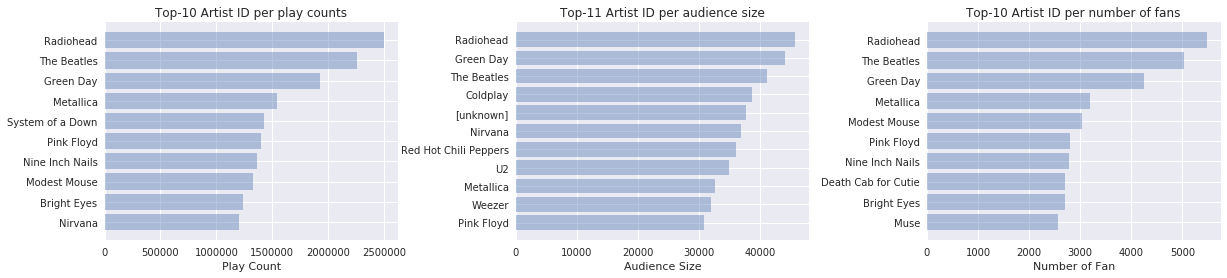

In [124]:
def displayHist(arg11, arg12, arg2, arg3, arg4):
    """displays a barplot from a list of arguments."""
    plt.barh(*arg11, **arg12)
    plt.yticks(*arg2)
    plt.xlabel(arg3)
    plt.title(arg4)

def giveName(df,pdf, n=10):
    """matches a name to an Artist's ID"""
    dfList = df.take(n)
    dictName= {x[0]:x[3] for x in dfList}
    Names = [dictName[x] for x in list(pdf[0][::-1])]  
    return(Names)

# calculate top-10 artists in term of play counts

#computation of the play counts of each artist
ArtistsPC = newUserArtistDF\
    .groupBy("ArtistID")\
    .sum("playCount")

#performs a join with the DataFrame that contains the names
topArtistsName = ArtistsPC\
    .join(artistDF, artistDF.artistID == ArtistsPC.ArtistID, 'inner')\
    .orderBy('sum(playCount)', ascending=0)

#extracts a list of the 10 top artists in term of play counts
top10ArtistsPC =ArtistsPC\
    .orderBy('sum(playCount)', ascending=0)\
    .take(10)  
    
y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsPC)

arg11 = [y_pos, pdf[1][::-1]]
arg12 = {'align':'center', 'alpha':0.4}
arg2 = [y_pos, giveName(topArtistsName, pdf)]
arg3 ='Play Count'
arg4 ='Top-10 Artist ID per play counts'
args1 = [arg11,arg12,arg2,arg3,arg4]

# calculate top-11 artists in term of number of audience size

#computation of the audience size of each artist
ArtistsAS = newUserArtistDF\
    .groupBy("ArtistID")\
    .count()

#performs a join with the DataFrame that contains the names
topArtistsName = ArtistsAS\
    .join(artistDF, artistDF.artistID == ArtistsAS.ArtistID, 'inner')\
    .orderBy('count', ascending=0)

#extracts a list of the 10 top artists in term of play counts
top11ArtistsAS =ArtistsAS\
    .orderBy('count', ascending=0)\
    .take(11)
    
y_pos = range(len(top11ArtistsAS))
pdf = pd.DataFrame(data=top11ArtistsAS)

arg11 = [y_pos, pdf[1][::-1]]
arg12 = {'align':'center', 'alpha':0.4}
arg2 = [y_pos,giveName(topArtistsName, pdf,11)]
arg3 ='Audience Size'
arg4 ='Top-11 Artist ID per audience size'
args2 = [arg11,arg12,arg2,arg3,arg4]

# calculate top-11 artists in term of the fan base size

#computation of the size of the fan base of each artist
ArtistsNF = newUserArtistDF\
    .filter("playCount > 100")\
    .groupBy("ArtistID")\
    .count()

#performs a join with the DataFrame that contains the names
topArtistsName = ArtistsNF\
    .join(artistDF, artistDF.artistID == ArtistsNF.ArtistID, 'inner')\
    .orderBy('count', ascending=0)

#extracts a list of the 10 top artists in term of play counts
top10ArtistsNF =ArtistsNF\
    .orderBy('count', ascending=0)\
    .take(10)   

y_pos = range(len(top10ArtistsNF))
pdf = pd.DataFrame(data=top10ArtistsNF)

arg11 = [y_pos, pdf[1][::-1]]
arg12 = {'align':'center', 'alpha':0.4}
arg2 = [y_pos,giveName(topArtistsName, pdf,10)]
arg3 ='Number of Fan'
arg4 ='Top-10 Artist ID per number of fans'
args3 = [arg11,arg12,arg2,arg3,arg4]

fig = plt.figure(figsize=(20, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 3, 1)
displayHist(*args1)
ax = fig.add_subplot(1, 3, 2)
displayHist(*args2)
ax = fig.add_subplot(1, 3, 3)
displayHist(*args3)

### Comments

<div class="alert alert-success">
<ul>
<li>Above are displayed 3 graphs, the first two were asked in the question. And the third one seemed interesting to me, we've seen that a lot of user only have a few of audience moreover listening once or twice to an artist is not really pertinent so I decided to look at the fanbase(users with >100 listenings of an artist).</li>
<li>For the second graph I displayed 11 Artists because we have an "unknown" artist which account for the song that cannot be labelised.</li>
<li>Globally, the 3 graphs are not too far from each other, for instance, the TOP3 is the same(unordered). Even though some artist create curiosity but have small "daily" users, eg: Coldplay, U2, Weezer, Red Hot Chili Peppers, Nirvana...</li>
<li>One the other hand some artists have a few hardcore fan because they appear on the first and third graph: Nine Inch Nails, Bright Eyes, Modest Mouse,...</li>
<li>Users are considered fan after 100 listenings and roughly artists tend to have a fan every 10 users. This is pretty high, I think it comes mainly from the fact that lot of people discover artists on TV, listening to the radio, on YouTube but not on a dedicated streaming platform where users have their habits.</li>
<li>Entries that have [unknown] as artist are useless. Excluding they would not be a problem, yet they only account for 38 000 entries which is negligeable in front of the 26 M entries. It would still be a shame to recommend an 'unknown' artist to a user.
</li>
</ul>

</div>

#### Question 5.3

<div class="alert alert-info">
Who are the top-10 users?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "curiosity", that is, how many different artists they listened to</li>

</ul>  

Plot the results
</div>

In [64]:
# calculate a list of the top 10 users in term of play counts
UsersByPlayCount = newUserArtistDF.groupBy("userID")\
    .sum("playCount")\
    .orderBy('sum(playCount)', ascending=0)

top10UsersByPlayCount = UsersByPlayCount.take(10)
    
y_pos = range(len(top10UsersByPlayCount))
pdf = pd.DataFrame(data=top10UsersByPlayCount)

arg11 = [y_pos, pdf[1][::-1]]
arg12 = {'align':'center', 'alpha':0.4}
arg2 = [y_pos,pdf[0][::-1]]
arg3 ='Play Count'
arg4 ='Top-10 Users ID per play counts'
args4 = [arg11,arg12,arg2,arg3,arg4]

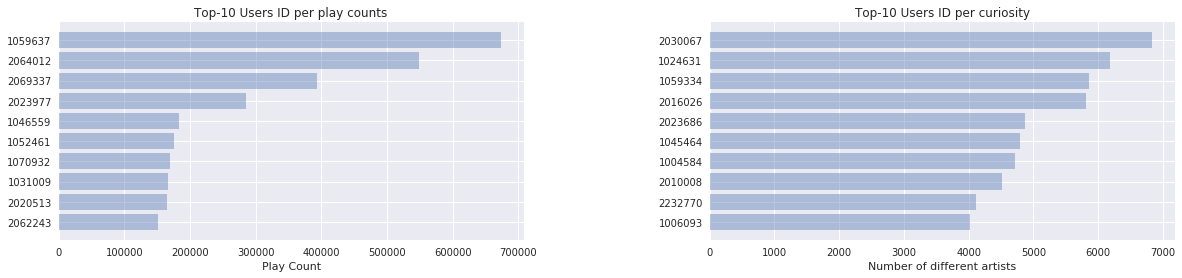

In [125]:
# calculate a list of the top 10 users in term of curiosity
UsersByCuriosity = newUserArtistDF.groupBy("userID")\
    .count()\
    .orderBy('count', ascending=0)

top10UsersByCuriosity = UsersByCuriosity.take(10)

    
y_pos = range(len(top10UsersByCuriosity))
pdf = pd.DataFrame(data=top10UsersByCuriosity)

arg11 = [y_pos, pdf[1][::-1]]
arg12 = {'align':'center', 'alpha':0.4}
arg2 = [y_pos,pdf[0][::-1]]
arg3 ='Number of different artists'
arg4 ='Top-10 Users ID per curiosity'
args5 = [arg11,arg12,arg2,arg3,arg4]
fig = plt.figure(figsize=(20, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
displayHist(*args4)
ax = fig.add_subplot(1, 2, 2)
displayHist(*args5)


### Comments

<div class="alert alert-success">
<ul>
<li>This data is pretty difficult to analyze. As mentioned before some users have huge play counts which look impossible to do in real life.</li>
<li>The Top10 is not valuable in this case, a correlation graph would be better. We are going to represent the users in an other way below.</li>
</ul>

</div>

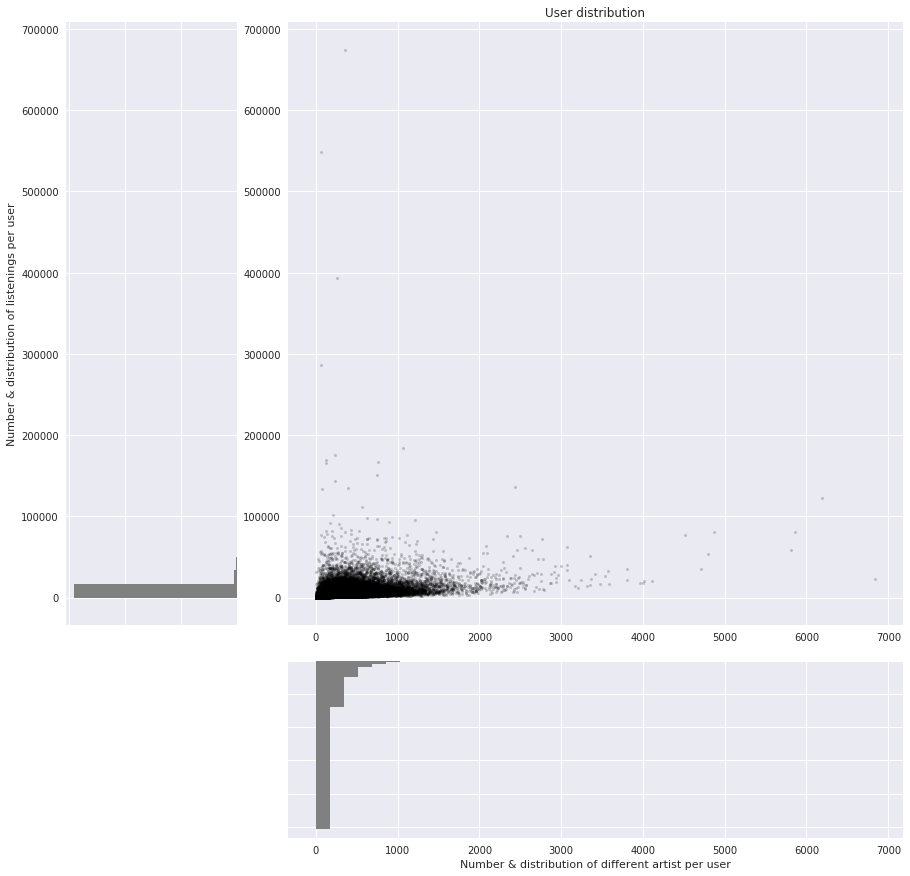

In [68]:
collerationStudy = UsersByCuriosity\
    .join(UsersByPlayCount, UsersByPlayCount.userID == UsersByCuriosity.userID, 'full')
collerationStudyPD = collerationStudy.toPandas()

x = collerationStudyPD['count'];
y = collerationStudyPD['sum(playCount)'];
# Set up the axes with gridspec
fig = plt.figure(figsize=(15,15))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.3)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(x, y, 'ok', markersize=3, alpha=0.2)

# label & title
x_hist.set_xlabel('Number & distribution of different artist per user')
y_hist.set_ylabel('Number & distribution of listenings per user')
main_ax.set_title('User distribution')

# histogram on the attached axes
x_hist.hist(x, 40, histtype='stepfilled',
            orientation='vertical', color='gray')
x_hist.invert_yaxis()

y_hist.hist(y, 40, histtype='stepfilled',
            orientation='horizontal', color='gray')
y_hist.invert_xaxis()

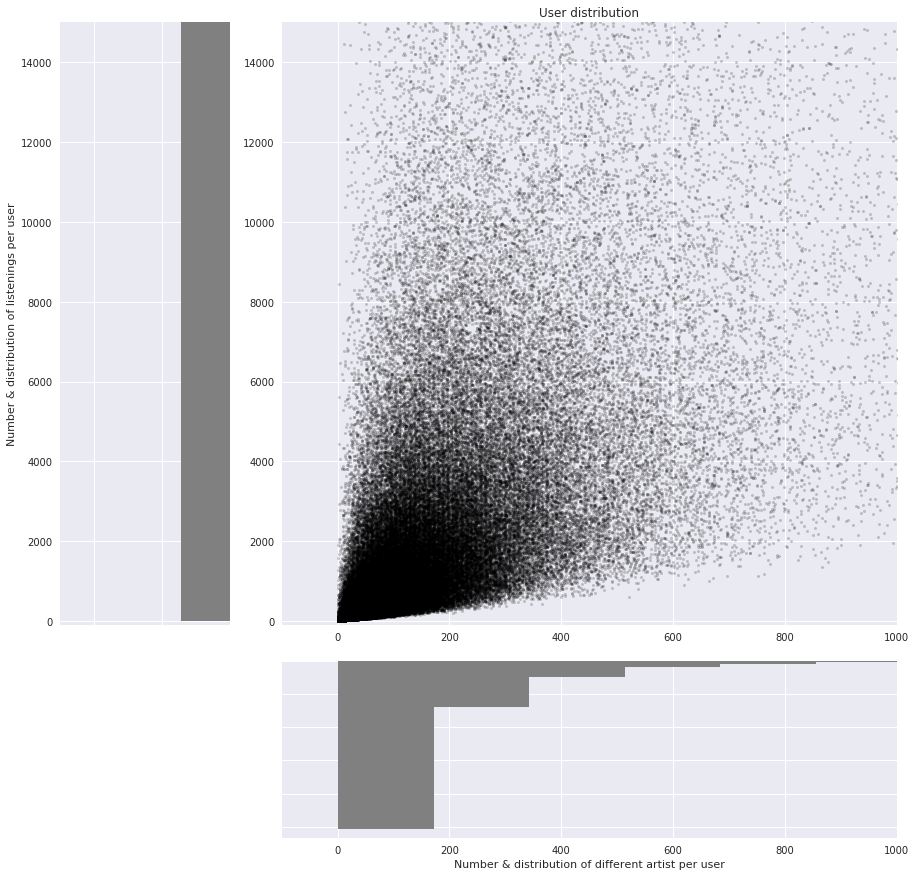

In [69]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(15,15))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.3)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(x, y, 'ok', markersize=3, alpha=0.2)

# label & title
x_hist.set_xlabel('Number & distribution of different artist per user')
y_hist.set_ylabel('Number & distribution of listenings per user')
main_ax.set_title('User distribution')

# limition of the axes
main_ax.set_xlim([-100,1000])
main_ax.set_ylim([-100,15000])
y_hist.set_ylim([-100,15000])
y_hist.set_xlim([-100,500000])
x_hist.set_xlim([-100,1000])

# histogram on the attached axes
x_hist.hist(x, 40, histtype='stepfilled',
            orientation='vertical', color='gray')
x_hist.invert_yaxis()

y_hist.hist(y, 40, histtype='stepfilled',
            orientation='horizontal', color='gray')
y_hist.invert_xaxis()

Now we have some valuable information about the data. It's the time to study how to build a statistical models.

### Comments

<div class="alert alert-success">
<ul>
<li>Looking at the data with a representation of each user in a Number of Songs/Number of Artists plane is giving us valuable insights on the distribution of the data.</li>
<li>One caracteristic of our data is the outliers. They have a huge value only in one of the feature "curiosity" or "number of sons played". They are very far to the top and to the right but very close along the diagonal. What can be deduced from it is that users that listen to music all the time are fan of a few artists but listen to them a lot (no curiosity & lots of listenings) and users who often switch artists are not fan of any artist and do not listen to music all the time(lots of curiosity & low number of listenings). It is seems logic, friendswho always have their headphones on are usually fan of Rock, Metal, Rap, techno... nearly-exclusivly.  </li>
<li>When we look at the second graph that is just a zoom of the first one, we can see that the cone of users is somewhat beautiful and that the distribution of number of artist is deacreasing while the one of song played seems constant at the beginning then nearly zero.</li>
<li>We could only select the data in the rectangle created by the point (2 000, 50 000) with the axis. It excludes the outliers but keeps most of the data.</li>
</ul>

</div>

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| | IT1 | IT2 | IT3 | ... | ITk |
|---|---|---|---|---|---|
| U1 | 1 |  | 5 | ... | 3 |
| U2 |  | 2 |  | ... | 2 |
| U3 | 5 |  | 3 | ... |  |
| U4 | 3 | 3 |  | ... | 4 |
| U5 |  | 1 |  | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate the best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is small. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we initialize the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row of $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


### 2.3.2 Matrix Factorization: Objective and ALS Algorithm on a Single Machine

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_m\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:


**Initialize** $X$, $Y$

**while(convergence is not true) do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_{ui} \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_{ui} \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_{ui} \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_{ui} \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**


For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### 2.3.3 Parallel Altenating Least Squares

There are several ways to distribute the computation of the ALS algorithm depending on how data is partitioned.

#### Method 1: using joins
First we consider a fully distributed version, in the sense that all data (both input and output) is stored in a distributed file system. In practice, input data (ratings) and parameters ($X$ and $Y$) are stored in an a Spark RDD. Specifically, ratings -- that are always **sparse** -- are stored as RDD of triplets:

Ratings: RDD((u, i, $r_{ui}$), . . . )


Instead, we can use dense representation for factor matrices $X$ and $Y$, and these are stored as RDDs of vectors. More precisely, we can use the data types introduced in Spark MLLib to store such vectors and matrices:

X : RDD($x_1$,...,$x_n$)

Y : RDD($y_1$,...,$y_m$)


Now, recall the expression to compute $x_u$:

$x_u = \left( \sum_{r_{ui} \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_{ui} \in r_{u*} r_{ui}} y_i $ 

Let's call the first summation *part A* and the second summation *part B*. To compute such parts, in parallel, we can proceed with the following high-level pseudocode:

* Join the Ratings RDD with the $Y$ matrix RDD using key $i$ (items)
* Map to compute $y_i y_{i}^{T}$ and emit using key $u$ (user)
* ReduceByKey $u$ (user) to compute $\sum_{r_{ui} \in r_{u*}} y_i y_{i}^{T}$
* Invert
* Another ReduceByKey $u$ (user) to compute $\sum_{r_{ui} \in r_{u*}} r_{ui} y_i$

We can use the same template to compute $y_i$.

This approach works fine, but note it requires computing $y_i y_{i}^{T}$ for each user that has rated item $i$. 

#### Method 2: using broadcast variables (advanced topic)
The next approach takes advantage of the fact that the $X$ and $Y$ factor matrices are often very small and can be stored locally on each machine.

* Partition the Ratings RDD **by user** to create $R_1$, and similarly partition the Ratings RDD **by item** to create $R_2$. This means there are two copies of the same Ratings RDD, albeit with different partitionings. In $R_1$, all ratings by the same user are on the same machine, and in $R_2$ all ratings for same item are on the same machine.
* Broadcast the matrices $X$ and $Y$. Note that these matrices are not RDD of vectors: they are now "local: matrices.
* Using $R_1$ and $Y$, we can use expression $x_u$ from above to compute the update of $x_u$ locally on each machine
* Using $R_2$ and $X$, we can use expression $y_i$ from above to compute the update of $y_i$ locally on each machine

A further optimization to this method is to group the $X$ and $Y$ factors matrices into blocks (user blocks and item blocks) and reduce the communication by only sending to each machine the block of users (or items) that are needed to compute the updates at that machine. 

This method is called **Block ALS**. It is achieved by precomputing some information about the ratings matrix to determine the "out-links" of each user (which blocks of the items it will contribute to) and "in-link" information for each item (which of the factor vectors it receives from each user block it will depend on). For exmple, assume that machine 1 is responsible for users 1,2,...,37: these will be block 1 of users. The items rated by these users are block 1 of items. Only the factors of block 1 of users and block 1 of items will be broadcasted to machine 1.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly. So, an algorithm which can run on a distributed system (SPARK, Hadoop...) is very suitable.

From these requirement, we can choose using ALS algorithm in SPARK's MLLIB.

Spark MLlib’s ALS implementation draws on ideas from [1](http://yifanhu.net/PUB/cf.pdf) and [2](http://link.springer.com/chapter/10.1007%2F978-3-540-68880-8_32).

## 3.2 Notes

Currently, MLLIB can only build models from an RDD. That means we have two ways to prepare data:

* Loading to into SPARK SQL DataFrame as before, and then access the corresponding RDD by calling `<dataframe>.rdd`. The invalid data is often sucessfully dropped by using mode `DROPMALFORMED`. However, this way might not work in all cases. Fortunately, we can use it with this usecase.

* Loading data directly to RDD. However, we have to deal with the invalid data ourself. In the trade-off, this way is the most reliable, and can work in every case.

In this notebook, we will use the second approach: it requires a bit more effort, but the reward is worth it!

 
## 3.3 Cleanup the data
In section 1, we already replaced the ids of mispelled artists by the corresponding standard ids by using SPARK SQL API.
However, if the data has the invalid entries such that SPARK SQL API is stuck, the best way to work with it is using an RDD.

Just as a recall, we work with three datasets in `user_artist_data.txt`, and  `artist_alias.txt`. The entries in these file can be empty or have only one field. 

In details our goal now is:

* Read the input ```user_artist_data.txt``` and transforms its representation into an output dataset.
* To produce an output "tuple" containing the original user identifier and play counts, but with the artist identifier replaced by its most common alias, as found in the ```artist_alias.txt``` dataset.
* Since the ```artist_alias.txt``` file is small, we can use a technique called **broadcast variables** to make such transformation more efficient.


### Question 6

#### Question 6.1

<div class="alert alert-info">
Load data from `/datasets/lastfm/artist_alias.txt` and filter out the invalid entries to construct a dictionary to map from mispelled artists' ids to standard ids.
</div>

NOTE: From now on, we will use the "standard" data to train our model.

HINT: If a line contains less than 2 fields or contains invalid numerial values, we can return a special tuple. After that, we can filter out these special tuples.

In [70]:
#For Google Cloud use:
#rawArtistAlias = sc.textFile("gs://dataproc-c4038cbd-7c98-485e-9ad2-fb5c00265b6a-eu/notebooks/artist_alias.txt")


rawArtistAlias = sc.textFile(base + "artist_alias.txt")

def xtractFields(s):
    """returns tuples (mispelledID, standartID) from artist_alias.txt"""
    # Using white space or tab character as separetors,
    # split a line into list of strings 
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

artistAlias = (
                rawArtistAlias
                    # extract fields using function xtractFields
                    .map(xtractFields)

                    # filter out the special tuples
                    .filter(lambda x: x != (-1,-1))

                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
                )

#### Question 6.2
<div class="alert alert-info">
Using the dictionary in question 6.1, prepare RDD `userArtistDataRDD` by replacing mispelled artists' ids to standard ids. Show 5 samples.
</div>

HINT: Using broadcast varible can help us increase the effiency.

### Comments

<div class="alert alert-success">
<p>Similarly to the DataFrame section of the Notebook we are cleaning the dictionnary that is used to clean the data.</p>
</div>

In [72]:
#toExcludeSet is the set of index who's match are themselves.
for x in toExcludeSet:
    del artistAlias[x]

#Here we are cleaning the dictionnary that substitute the mispelledID with the standardID.
#We are re-using functions already defined in the first part of the norebook
while checkIfOk(artistAlias):
    for x in artistAlias:
        artistAlias[x] = findGoodAlias(x)

#For Google Cloud use:
#rawUserArtistData = sc.textFile("gs://dataproc-c4038cbd-7c98-485e-9ad2-fb5c00265b6a-eu/notebooks/user_artist_data.txt")



bArtistAlias = sc.broadcast(artistAlias)
rawUserArtistData = sc.textFile(base + "user_artist_data.txt")


def disambiguate(line):
    """returns tuples (userID, realArtistID, count from user_artist_data.txt)"""
    [userID, artistID, count] = line.split(' ')
    finalArtistID = bArtistAlias.value.get(artistID, artistID) #it is important to use .get() to have a default value
    return ((userID, finalArtistID), count)

userArtistDataRDD = rawUserArtistData.map(disambiguate)
userArtistDataRDD.take(5)

[(('1000002', '1'), '55'),
 (('1000002', '1000006'), '33'),
 (('1000002', '1000007'), '8'),
 (('1000002', '1000009'), '144'),
 (('1000002', '1000010'), '314')]

## 3.4 Training our statistical model
To train a model using ALS, we must use a preference matrix  as an input. MLLIB uses the class `Rating` to support the construction of a distributed preference matrix.

### Question 7

#### Question 7.1
<div class="alert alert-info">
Given RDD `userArtistDataRDD` in question 6.2, construct a new RDD `trainingData` by tranforming each item of it into a `Rating` object.
</div>

In [73]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [74]:
from operator import add

# after replacing mispelled artist ids, the data contains some play count duplications of a user with the same artist
# remember to aggregate these records
allData = userArtistDataRDD\
    .reduceByKey(add)\
    .map(lambda r: Rating(r[0][0], r[0][1], r[1]))\
    .repartition(4)\
    .cache()
allData.take(5)

[Rating(user=1000282, product=1004440, rating=2.0),
 Rating(user=1000329, product=1004535, rating=1.0),
 Rating(user=1000465, product=6771478, rating=3.0),
 Rating(user=1000544, product=1011605, rating=2.0),
 Rating(user=1000623, product=1, rating=12.0)]

#### Question 7.2
<div class="alert alert-info">
A model can be trained by using `ALS.trainImplicit(<training data>, <rank>)`, where:
<ul>
<li>`training data` is the input data you decide to feed to the ALS algorithm</li>
<li>`rank` is the number of laten features</li>
</ul>  


We can also use some additional parameters to adjust the quality of the model. Currently, let's set 
<ul>
<li>`rank=10`</li>
<li>`iterations=5`</li>
<li>`lambda_=0.01`</li>
<li>`alpha=1.0` </li>
</ul>
to build model.
</div>

In [75]:
t0 = time()
model = ALS.trainImplicit( allData, rank = 10, iterations=5, lambda_=0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 54.224361 secs


#### Question 7.3
<div class="alert alert-info">
The trained model can be saved into HDFS for later use. This can be done via `model.save(sc, <file_name>)`.
Let's use this function to store our model as name `lastfm_model.spark`.
</div>

NOTE 1: since you may have noticed that building the model takes some time, it might come to your mind that this information could be stored, such that you can "interrupt" your laboratory session here, and restart next time by loading your model.

NOTE 2: funnily enough, it could take more time to save the model than to build it from scratch! So take a look at the execution time to save the model: this method actually stores the model as Parquet files, which are column-oriented and compressed.

NOTE 3: to check you have your file on HDFS, you are invited to open a terminal from the "Home" Jupyter dashboard, and type `hdfs dfs -ls` to check.

In [76]:
#For Google Cloud use:
#model.save( sc, "gs://dataproc-c4038cbd-7c98-485e-9ad2-fb5c00265b6a-eu/notebooks/lastfm_model.spark")

! hdfs dfs -rm -R -f -skipTrash lastfm_model.spark
model.save( sc, "lastfm_model.spark")

Deleted lastfm_model.spark


In [77]:
%ls ./..

datasets/  workspace/


#### Question 7.4
<div class="alert alert-info">
A saved model can be load from file by using `MatrixFactorizationModel.load(sc, <file_name>)`. 

Let's load our model from file.
</div>

In [78]:
#For Google Cloud use:
#model = MatrixFactorizationModel.load( sc, "gs://dataproc-c4038cbd-7c98-485e-9ad2-fb5c00265b6a-eu/notebooks/lastfm_model.spark")


t0 = time()
model = MatrixFactorizationModel.load( sc, "lastfm_model.spark")
t1 = time()
print("finish loading model in %f secs" % (t1 - t0))

finish loading model in 2.079205 secs


#### Question 7.5
<div class="alert alert-info">
Print the first row of user features in our model.
</div>

In [79]:
type(model.userFeatures())
print(model.userFeatures().first())

(116, array('d', [0.02794540859758854, 0.04372737929224968, -0.031649332493543625, 0.031216919422149658, -0.05210841819643974, -0.021128889173269272, 0.005251260008662939, -0.00983426533639431, -1.9240491383243352e-05, -0.05921049788594246]))


### Comments

<div class="alert alert-success">
Later in this Notebook the Area under the RO Curve (AUROC) will be used to assess our models. But one classic metric is left aside : Root Square Mean Error. 
Below is an implementation of the computation of the RSME inspired from the MLlib movie recommender turorial. This metric can assess if recommendation will be adapted to the user or not but it will give us information on the quality on the matrix factorisation which is interesting.
</div>

In [82]:
def computeRmse(model, data):

    #computation of all the prediction
    predictions = model.predictAll(data.map(lambda x: (x[0], x[1])))
    #puting them in a nice shape
    predictionsAndRatings = predictions.map(lambda x: ((x[0], x[1]), x[2])) \
      .join(data.map(lambda x: ((x[0], x[1]), x[2]))) \
      .values()
    #computation of the RSME over all the values
    n, avg = predictionsAndRatings.map(lambda x: (1,(x[0] - x[1]) ** 2)).reduce(lambda x,y: (x[0]+y[0], x[1]+y[1]))
    return ((np.sqrt(avg))/n)

computeRmse(model, allData)

0.031365843979742646

### Comments

<div class="alert alert-success">
In average, the 'new' matrix's cells are $0.031$ off from the 'original' matrix's cells which seems to be a good number. It is means that the matrix is nicely approximated and we have good reasons to believe that originaly empty cells will be filled with a number represented the interest of the user towards the item. It is difficult to see from this lone RSME if it is good or not. At the end of the Notebook an additional section will go deeper on this question.
</div>

### Question 8
<div class="alert alert-info">
Show the top-5 artist names recommendated for a given user, for example: `2093760` (please, try with different users!).
</div>

HINT: The recommendations can be given by function `recommendProducts(userID, num_recommendations)`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`.

In [83]:
# Make five reccommendations to user 2093760
recommendations = (model.recommendProducts(2093760,5))


# construct set of recommendated artists
recArtist = set(r[1] for r in recommendations )
print(recArtist)
recommendations

{1300642, 1037970, 1007614, 1001819, 2814}


[Rating(user=2093760, product=1300642, rating=0.030813295610160548),
 Rating(user=2093760, product=1037970, rating=0.03062488556182823),
 Rating(user=2093760, product=1007614, rating=0.02980278000422848),
 Rating(user=2093760, product=2814, rating=0.029750885874321478),
 Rating(user=2093760, product=1001819, rating=0.029733009098133516)]

In [85]:
#For Google Cloud use:
#rawArtistData = sc.textFile("gs://dataproc-c4038cbd-7c98-485e-9ad2-fb5c00265b6a-eu/notebooks/artist_data.txt")


# construct data of artists (artist_id, artist_name)

rawArtistData = sc.textFile(base + "artist_data.txt")


def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)

# Filter in those artists, get just artist, and print
def artistNames(line, recArtist):
#     [artistID, name]
    if ( line[0] in recArtist):
        return True
    else:
        return False

recList = artistByID.filter(lambda x : artistNames(x, recArtist)).values().collect()
print(recArtist)
print(recList)

{1300642, 1037970, 1007614, 1001819, 2814}
['50 Cent', 'Jay-Z', 'Kanye West', '2Pac', 'The Game']


### Comments

<div class="alert alert-success">
Right now, we should be attacked by dozens of questions.
<ul>
<li>Are those artists new to the user or not ? It should be otherwise it is useless.</li>
<li>Are those artists in the same musical area than the artists that cumulate the most listenings from the user ?</li>
<li>By running multiple time the code above after re-training we sometimes find different set of artists : Snoop Dogg, Kanye West, 2Pac, 50 Cent',Jay-Z, Dr. Dre, The Game.</li>
</ul>
<p>We are going to automatize this process through functions then, we will create a function that displays the Top artist for a given user and we will be able to see if it is logic.</p>
</div>

In [87]:
def recommendFor(model, userID, n):
    rec = (model.recommendProducts(userID, n))
    recArtist = set(r[1] for r in rec )
    artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)
    recList = artistByID.filter(lambda x : artistNames(x, recArtist)).values().collect()
    return(recList)

def topArtistOfUser(userID, n):
    filterUserID = "userId ==" + str(userID)
    ArtistsOfUser = newUserArtistDF\
        .filter(filterUserID)\
        .orderBy('playCount', ascending=0)\
        .limit(n)

    topArtistsName = ArtistsOfUser\
        .join(artistDF, artistDF.artistID == ArtistsOfUser.artistID, 'inner')
        
    out = topArtistsName
    print("The user's favored artists:")
    return(out.toPandas().loc[:, ['name', 'playCount']].sort_values(by=['playCount'], ascending=False))

In [88]:
topArtistOfUser(2093760,5)

The user's favored artists:


,name,playCount
4,Xzibit,7
3,The Saw Doctors,3
2,Jurassic 5,2
0,David Gray,1
1,Blackalicious,1


In [89]:
recommendFor(model,2093760,5)

['50 Cent', 'Jay-Z', 'Kanye West', '2Pac', 'The Game']

### Comments
<div class="alert alert-success">
<p> Let's look at the musical genre.</p>
</div>

| listened artists| genre |
|----|----|
| David Gray|rock|
| Blackalicious| rap West Coast|
| Jurassic 5|hip hop|
| The Saw Doctors|rock|
| Xzibit| rap West Coast|

| rec artists| genre |
|----|----|
| 50 Cent| rap East Coast|
| Kanye West| rap|
| Jay-Z| rap East Coast|
| 2Pac| rap West Coast|
| The Game| rap West Coast|

### Comments

<div class="alert alert-success">
<ul>
<li>For a first recommendation, it is interesting. Clearly, the user `2093760` likes rap, more precisely West Coast rap and our recommendations give him 5 artists of that genre. In real life, those recommendation woud maybe end up by a click from the user.</li>
<li> The user has listened to only a dozen of tracks which around 10 of them are rap or hip hop. we can understant why rap is so predominant in the recommendations. Moreover the recommendations are new to the user.</li>
Let's try other users.
</ul>
</div>

In [90]:
print("recommeded artists: {}".format(recommendFor(model,1000070,15)))
print("")
topArtistOfUser(1000070,5)

recommeded artists: ['Kyuss', 'Turbonegro', 'Johnny Cash', 'Ramones', 'The Doors', 'Pixies', 'Nick Cave and the Bad Seeds', 'Joy Division', 'Led Zeppelin', 'Radiohead', 'Nirvana', 'Pink Floyd', 'John Frusciante', 'Queens of the Stone Age', 'Faith No More']

The user's favored artists:


,name,playCount
3,Nine Inch Nails,2466
1,The Beatles,1210
2,Radiohead,1187
4,Manic Street Preachers,1175
0,Pixies,1027


In [91]:
print(recommendFor(model,1000832,15))
topArtistOfUser(1000832,5)

['KMFDM', '[unknown]', 'VNV Nation', 'Apocalyptica', 'A Perfect Circle', 'The Prodigy', 'Placebo', 'Depeche Mode', 'Tool', 'Massive Attack', 'Porcupine Tree', 'Pink Floyd', 'Rammstein', 'Nine Inch Nails', 'Marilyn Manson']
The user's favored artists:


,name,playCount
0,Dead Can Dance,58
2,Anathema,49
3,Electric Rudeboyz,48
1,Massive Attack,44
4,Death in June,39


### Comments

<div class="alert alert-success">
<ul>
<li> Again the recommendations look pretty good. The musical genre are similar even though some users are very active and other are clearly less active.</li>
<li> We see that for users `1000070` the Pixies are both in recommendations and previously listened artists. And that user `1000832` received a recommendation for the [unknown] artist.</li>
<li> Something that is intersting is that the `model` is different depending on where it is computed ! The model computed here on <i>Zoe Analytics</i> has different values from the one computed on my <i>Google Cloud DataProc Cluster</i>. Both are running <i>Apache Spark 2.2.0</i>, they are maybe using different version of the ALS algorithm or different python's seed value.</li>
</ul>
</div>

<div class="alert alert-danger">
At the moment, it is necessary to manually unpersist the RDDs inside the model when you are done with it. The following function can be used to make sure models are promptly uncached.
</div>

In [92]:
def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# uncache data and model when they are no longer used  
unpersist(model)

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide the some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
<div class="alert alert-info">
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:
<ul>
<li>`rank`=10</li>
<li>`iterations`=5</li>
<li>`lambda_`=0.01</li>
<li>`alpha`=1.0</li>
</ul>
</div>

In [93]:
trainData, cvData = allData.randomSplit([0.9,0.1])
trainData.cache()
cvData.cache()

t0 = time()
model = ALS.trainImplicit( trainData, rank = 10, iterations=5, lambda_=0.01, alpha=1.0 )

t1 = time()
print("finish training model in %f secs" % (t1 - t0))



finish training model in 74.660197 secs


#### Area under the ROC curve: a function to compute it

In [94]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [95]:
from random import randint

# Depend on the number of item in userIDAndPosItemIDs,
# create a set of "negative" products for each user. These are randomly chosen
# from among all of the other items, excluding those that are "positive" for the user.
# NOTE 1: mapPartitions operates on many (user,positive-items) pairs at once
# NOTE 2: flatMap breaks the collections above down into one big set of tuples
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        allItemIDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(allItemIDs) and len(negative) < len(posItemIDSet)):
            itemID = allItemIDs[randint(0,len(allItemIDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1
        
        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)

def ratioOfCorrectRanks(positiveRatings, negativeRatings):
    
    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
    ## AUC may be viewed as the probability that a random positive item scores
    ## higher than a random negative one. Here the proportion of all positive-negative
    ## pairs that are correctly ranked is computed. The result is equal to the AUC metric.
    correct = 0 ## L
    total = 0 ## L
    
    # sorting positiveRatings array needs more cost
    #positiveRatings = np.array(map(lambda x: x.rating, positiveRatings))

    negativeRatings = list(map(lambda x:x.rating, negativeRatings))
    
    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)
        
    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)
    
    # Create a set of "negative" products for each user. These are randomly chosen 
    # from among all of the other items, excluding those that are "positive" for the user. 
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(xtractNegative).flatMap(lambda x: x)
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])
                )
                .mean()
            )

####  Question 9.2
<div class="alert alert-info">
Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.
</div>

In [58]:
t0 = time()
auc = calculateAUC( cvData, bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))

auc= 0.964076491427185
finish in 67.254150 seconds


### Comments

<div class="alert alert-success">
<p>We are calculating the area under the ROC (AUROC) which is a metric used to evaluate binary classifiers. The label positive here is that the artist is "good" i.e it has been held-out. It is rightly classified if it is ranked at the top of the ranking list for a user. Value of $1$ depicts a perfect classifer, in our case we fluctuate between 0.96 and 0.97 which is pretty high. Since the volume of user is huge a tenth of percent is a good improvement.</p>

<p>Moreover it means that if we propose a handful of artists(Like it is done on YouTube, Deezer,...) from the top of the ranking list for a given user the propability that at least one artist is labeled as "good" is nearly 1. This makes the AUROC an especially interesting metric for recommender systems. Yet our  `calculateAUC` function is an estimation of the true AUROC that would be too expensive to compute, we have to keep in mind that we have an estimation of a probability, we are far from a strong and stabe metric like we could have in a supervised problem.
</p>

</div>

#### Question 9.3
<div class="alert alert-info">
Now we have the UAC of our model, it’s helpful to benchmark this against a simpler approach. For example, consider recommending the globally most-played artists to every user. This is not personalized, but is simple and may be effective.   
<ul></ul>
Implement this simple pupolarity-based prediction algorithm, evaluate its AUC score, and compare to the results achieved by the more sophisticated ALS algorithm.
</div>

In [59]:
bListenCount = sc.broadcast(trainData.map(lambda r: (r[1], r[2])).reduceByKey(lambda a,b: a+b).collectAsMap())
def predictMostListened(allData):
    return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get(r[1], 0.0)))

In [60]:
auc = calculateAUC(cvData, bAllItemIDs, predictMostListened)
print(auc)

0.937020903555523


### Comments

<div class="alert alert-success">
<p>We see that giving the "best" artist to everybody is not a terrible idea, it is not personalized but for new users it seems like a good idea when we look at the AUROC value. In terms of probability, the recommendation will likely interest the user.</p>

<p>The fact that such a poor and simple model performs so well means that every little improvement do actually mean something. In addition the metric we use is maybe not so telling. We want to give personalized recommendations and giving brainlessly the few best artists to everybody seems okay according to our evaluation method.</p>

</div>

## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given paramters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
<div class="alert alert-info">
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.
</div>

```python
evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit( ... )
            
            auc = calculateAUC( ... )
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)

evaluations.sort( ... )
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()
```

In [61]:
evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit( trainData, rank = rank, iterations=5, lambda_=lambda_, alpha=alpha )
            
            auc = calculateAUC( cvData, bAllItemIDs, model.predictAll )
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)

evaluations.sort( key = lambda e:e[1], reverse=True )
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist();

Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=50 lambda_=1.000000 alpha=1.000000
Train model with rank=50 lambda_=1.000000 alpha=40.000000
Train model with rank=50 lambda_=0.000100 alpha=1.000000
Train model with rank=50 lambda_=0.000100 alpha=40.000000
                    0         1
0     (10, 1.0, 40.0)  0.976675
1     (50, 1.0, 40.0)  0.975819
2  (10, 0.0001, 40.0)  0.975564
3  (50, 0.0001, 40.0)  0.974970
4      (10, 1.0, 1.0)  0.969109
5      (50, 1.0, 1.0)  0.967082
6   (10, 0.0001, 1.0)  0.965315
7   (50, 0.0001, 1.0)  0.953592


### Comments

<div class="alert alert-success">
<p>We have done a <i>grid search</i> in order to optimize the hyperparameters this method is very expensive in computations but it is very useful because it permits us to find the best hyperparameters for our model. We found that $10$ is the better rank, the rank are the latent factors and account for the model complexity. Lambda_ = $1$ and alpha = $40$ produce the best result among our proposed values.</p>

<p> Around $1.3$% has been won by a simple grid search. Those $1.3$% are very important considering that the simplest recommendation system is arounf $93$% and that this permits us to jump for $96.3$% to $97.6$%. Grid search is limited by our ressources but it is very important to optimize hyper-parameters.
</div>

#### Question 10.2 
<div class="alert alert-info">
Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user `2093760`.
</div>

```python
model = ALS.trainImplicit( ... )
allData.unpersist()

userID = 2093760
recommendations = model.recommendProducts(...)

recommendedProductIDs = set( ... )

recList = artistByID. ...
print(recList)

unpersist(model)
```

In [62]:
model = ALS.trainImplicit( trainData, rank = 10, iterations=5, lambda_=1.0, alpha=40.0 )
allData.unpersist();

In [63]:
userID = 2093760
recommendFor(model,2093760, 5)

['50 Cent', '[unknown]', 'Eminem', 'Green Day', 'blink-182']

### Comments

<div class="alert alert-success">

<p> Even though there has been data-cleaning, We still have some meaningless artists `[unknown]`, `various artists` and more... It is difficult to get rid of all of them. Since they account of a very little number of listenings we will let them be.</p>
<p>The recommendations for `2093760` now have a some rock artists in addition to the rap artist which is good considering that we saw that `2093760` listened to some rock.</p>

</div>

<div class="alert alert-success">

<p> Let's go a bit deeper with this Notebook. With 4 additional sections:</p>
<ol>
<li>Wider grid search</li>
<li>Simple cross validation</li>
<li>Impact of outliers</li>
<li>Impact of number of iteration evaluated with the RSME</li>
</ol>

<p>We can notice that some of the best value are the biggest values that were tested through the grid search so we need to extend the range of tested values therefore we are going to test with biggest values. This pushes us to try other values in a new grid search.</p>

</div>


# Wider grid search
<div class="alert alert-success">

</div>

In [64]:
evaluations = []

for rank in [23, 36]:
    for lambda_ in [4.0, 6.0]:
        for alpha in [90.0, 120.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit( trainData, rank = rank, iterations=5, lambda_=lambda_, alpha=alpha )
            
            auc = calculateAUC( cvData, bAllItemIDs, model.predictAll )
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)

evaluations.sort( key = lambda e:e[1], reverse=True )
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist();

Train model with rank=23 lambda_=4.000000 alpha=90.000000
Train model with rank=23 lambda_=4.000000 alpha=120.000000
Train model with rank=23 lambda_=6.000000 alpha=90.000000
Train model with rank=23 lambda_=6.000000 alpha=120.000000
Train model with rank=36 lambda_=4.000000 alpha=90.000000
Train model with rank=36 lambda_=4.000000 alpha=120.000000
Train model with rank=36 lambda_=6.000000 alpha=90.000000
Train model with rank=36 lambda_=6.000000 alpha=120.000000
                  0         1
0  (36, 6.0, 120.0)  0.989276
1   (36, 6.0, 90.0)  0.987572
2  (36, 4.0, 120.0)  0.987008
3  (23, 6.0, 120.0)  0.985985
4   (23, 4.0, 90.0)  0.984828
5   (36, 4.0, 90.0)  0.984543
6   (23, 6.0, 90.0)  0.984514
7  (23, 4.0, 120.0)  0.983868


### Comments

<div class="alert alert-success">
<p>Again, we have some of the best values that are the biggest values tested. We should do another grid search.</p>
<p>Here the best are $36$, $6.0$ and $120.0$</p>

</div>

In [66]:
evaluations = []

for rank in [40, 45]:
    for lambda_ in [7.0, 9.0]:
        for alpha in [140.0, 200.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit( trainData, rank = rank, iterations=5, lambda_=lambda_, alpha=alpha )
            
            auc = calculateAUC( cvData, bAllItemIDs, model.predictAll )
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)

evaluations.sort( key = lambda e:e[1], reverse=True )
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist();

Train model with rank=40 lambda_=7.000000 alpha=140.000000
Train model with rank=40 lambda_=7.000000 alpha=200.000000
Train model with rank=40 lambda_=9.000000 alpha=140.000000
Train model with rank=40 lambda_=9.000000 alpha=200.000000
Train model with rank=45 lambda_=7.000000 alpha=140.000000
Train model with rank=45 lambda_=7.000000 alpha=200.000000
Train model with rank=45 lambda_=9.000000 alpha=140.000000
Train model with rank=45 lambda_=9.000000 alpha=200.000000
                  0         1
0  (40, 9.0, 200.0)  0.991713
1  (45, 7.0, 200.0)  0.991352
2  (40, 9.0, 140.0)  0.990806
3  (40, 7.0, 200.0)  0.990648
4  (45, 9.0, 200.0)  0.990292
5  (45, 7.0, 140.0)  0.990213
6  (40, 7.0, 140.0)  0.989579
7  (45, 9.0, 140.0)  0.989109


### Comments

<div class="alert alert-success">

<p>We see that with a wider grid search we can go beyond the $99^{th}$ percentile !! Given the first results around $97.6$% percent, we have at least a $1.5$% improvement that can reveal itself very important if the user base is composed of a few million users. The grid search process is very long ( ~2h30 for the whole notebook) but the improvment is worth it.</p>

<p>I have doubts over the best found model : ($40$, $9.0$, $200.0$), I think it may be overfitting on the test data.

</div>

In [70]:
model = ALS.trainImplicit( allData, rank = 40, iterations=5, lambda_=9.0, alpha=200.0 )

In [71]:
recommendFor(model,2093760, 5)

['[unknown]', 'Eminem', 'Various Artists', 'Green Day', 'blink-182']

### Comments

<div class="alert alert-success">

<p> It is a shame to recommend `[unknown]` and `Various Artists` but since it is in our data...</p>
<p> Let's see what happends if we change the `cvData` and `trainData` because there is a risk of overfitting on the test data. </p>

</div>

# Simple cross validation

<div class="alert alert-success">
</div>

<div class="alert alert-success">


<p> Here we are going to compute the AUROC for several models 3 times. Each time with a different training/testing dataset to evaluate the hyperparameters found previously. </p>

</div>

In [69]:
evaluations = []

for ite in range(1, 4):
    trainData, cvData = allData.randomSplit([0.9,0.1])
    trainData.cache()
    cvData.cache()
    for rank in [10 , 40]:
        for lambda_ in [1.0, 9.0]:
            for alpha in [40.0, 200.0]:
                print("Train model with rank=%d lambda_=%f alpha=%f iteration=%d" % (rank, lambda_, alpha, ite ))
                # with each combination of params, we should run multiple times and get avg
                # for simple, we only run one time.
                model = ALS.trainImplicit( trainData, rank = rank, iterations=5, lambda_=lambda_, alpha=alpha )
            
                auc = calculateAUC( cvData, bAllItemIDs, model.predictAll )
            
                evaluations.append(((rank, lambda_, alpha, ite), auc))
            
                unpersist(model)
    trainData.unpersist()
    cvData.unpersist();

evaluations.sort( key = lambda e:e[1], reverse=True )
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist();

Train model with rank=10 lambda_=1.000000 alpha=40.000000 iteration=1
Train model with rank=10 lambda_=1.000000 alpha=200.000000 iteration=1
Train model with rank=10 lambda_=9.000000 alpha=40.000000 iteration=1
Train model with rank=10 lambda_=9.000000 alpha=200.000000 iteration=1
Train model with rank=40 lambda_=1.000000 alpha=40.000000 iteration=1
Train model with rank=40 lambda_=1.000000 alpha=200.000000 iteration=1
Train model with rank=40 lambda_=9.000000 alpha=40.000000 iteration=1
Train model with rank=40 lambda_=9.000000 alpha=200.000000 iteration=1
Train model with rank=10 lambda_=1.000000 alpha=40.000000 iteration=2
Train model with rank=10 lambda_=1.000000 alpha=200.000000 iteration=2
Train model with rank=10 lambda_=9.000000 alpha=40.000000 iteration=2
Train model with rank=10 lambda_=9.000000 alpha=200.000000 iteration=2
Train model with rank=40 lambda_=1.000000 alpha=40.000000 iteration=2
Train model with rank=40 lambda_=1.000000 alpha=200.000000 iteration=2
Train model w

In [90]:
#We get rid of the 4th number that is describing the dataset in order to do a GroupBy
evalDataFrame[0] = evalDataFrame[0].apply(lambda x: (x[0], x[1], x[2]))
#We GroupBy by each moel and compute the mean.
evalDataFrameGB = evalDataFrame\
    .groupby(0)\
    .mean()
evalDataFrameGB.sort_values(by=1, ascending=False)

,1
0,
"(40, 9.0, 200.0)",0.989211
"(40, 1.0, 200.0)",0.988832
"(40, 9.0, 40.0)",0.984536
"(40, 1.0, 40.0)",0.983143
"(10, 9.0, 200.0)",0.980184
"(10, 1.0, 200.0)",0.980159
"(10, 9.0, 40.0)",0.977300
"(10, 1.0, 40.0)",0.975882


<div class="alert alert-success">

<p> This simple average over 3 different cross-validation training on $90$% and testing on $10$% helps us to truly assess our different models. The best model : ($40$, $9.0$, $200.0$) was exepected because it was the best after the wider grid search. Yet we can see that the percentage is a bit lower at $98.92$% while we were at $99.17$% the first time but we are now sure that it was not an overfit on the $10$% test data since we changed between each iteration of the validation.</p>

<p>The worst result in the validation is the best result of the first grid search that was asked by the notebook, the results are similar at $97.5$%. This additional validation is good since it gives us more insights on our models behave in general and without being in a specific case.</p>

<p> We can also draw a hierarchy between the hyperparameters. In terms of impact on the AUROC : `rank > alpha > lambda_`.
</div>

# Impact of outliers

<div class="alert alert-success">

<p>As mentionned in the first part of the Notebook with the representation of the users in the number of listenings/number of artists plane we see that our dataset has clear outliers. We can classify them in 2 categories: </p>
<ul>
<li> over-active users : They have listened to too much tracks to be realistics, they boost and pull some artists to the top nearly alone. Usualy they listen to a rather limited number of artists.</li>
<li> over-curious users : They listen to a huge number of differents artists, they behaviour is similar to  randomly playing songs. </li>

<p>Moreover we noticed that without outliers the dataset forms a beatiful cone is the plane desribed above. We are going to select only users having less than $50 000$ listenings and less than $3000$ different artists in order to exclude the 2 categories of outliers identified above. </p>

<p> For this study of the impact of the outliers, we are going to use the $10$, $1.0$ and $40.0$ hyperparameters to be able to compare with perviously computed values.
</div>

In [97]:
#We go from ((userID,artistID), Count) to (userID, (1, Count))
usersArtistsReformedRDD = userArtistDataRDD\
    .map(lambda x : (int(x[0][0]),(1 , int(x[1]))))
         
#extracts a dictionnary with each index being a "good" user
usersLimitDICT = usersArtistsReformedRDD\
    .reduceByKey(lambda x, y : (x[0] + 1, x[1] + y[1] ))\
    .filter(lambda x : x[1][1]< 50001)\
    .filter(lambda x : x[1][0]< 3001)\
    .map(lambda x : (x[0], 1))\
    .collectAsMap()



In [98]:
#We go from ((userID,artistID), Count) and filter with the dict created above
usersArtistsReformedRDD = userArtistDataRDD\
    .map(lambda x : ((int(x[0][0]),x[0][1]) , int(x[1])))\
    .filter(lambda x : x[0][0] in usersLimitDICT)


In [99]:
usersArtistsReformedRDD.filter(lambda x : x[0][0] == 2093760 ).take(5)

[((2093760, '1180'), 1),
 ((2093760, '1255340'), 3),
 ((2093760, '378'), 1),
 ((2093760, '813'), 2),
 ((2093760, '942'), 7)]

In [100]:
noOutiliersData = usersArtistsReformedRDD\
    .reduceByKey(add)\
    .map(lambda r: Rating(r[0][0], r[0][1], r[1]))\
    .repartition(4)\
    .cache()

In [101]:
noOutiliersData.take(5)

[Rating(user=2399948, product=1327894, rating=2.0),
 Rating(user=2399948, product=6710785, rating=7.0),
 Rating(user=2399949, product=693, rating=1.0),
 Rating(user=2399981, product=1285044, rating=2.0),
 Rating(user=2400012, product=253, rating=18.0)]

In [103]:
unpersist(model)
t0 = time()
model = ALS.trainImplicit( noOutiliersData, rank = 10, iterations=5, lambda_=1.0, alpha=40.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))



finish training model in 67.009108 secs


In [104]:
recommendFor(model,2093760,5)

['[unknown]', 'The Killers', 'Weezer', 'Green Day', 'blink-182']

### Comments

<div class="alert alert-success">
<p> Those recommendations are pretty close to the previous one. We see that `Jay-Z and Linkin Park` appears this is probably an artist with few listenings because it is a collaboration</p> 
<p> Let's look at the AUROC</p>
</div>

In [106]:
unpersist(model)
trainReformedData, cvReformedData = noOutiliersData.randomSplit([0.9,0.1])
trainReformedData.cache()
cvReformedData.cache()

t0 = time()
model = ALS.trainImplicit( trainReformedData, rank = 10, iterations=5, lambda_=1.0, alpha=40.0 )

t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 78.085059 secs


In [107]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(noOutiliersData\
                      .map(lambda x: x[1])\
                      .distinct()\
                      .collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [108]:
auc = calculateAUC( cvReformedData, bAllItemIDs, model.predictAll )
trainReformedData.unpersist()
cvReformedData.unpersist();

In [109]:
print(auc)

0.9770476773169393


### Comments

<div class="alert alert-success">
<p> The difference is not really observable compared with the ($10$, $1.0$, $40.0$) from the cross validations that was around $97.5$%. The only insight that be get is that our model is strong and stable even if we modify the dataset and exclude the outliers.</p> 

</div>

# Impact of number of iteration evaluated with the RSME

<div class="alert alert-success">

<p> We've already introduced the notion of RSME in this Notebook before. It is adviced to take the `iterations` parameter egal to 5 but we don't really know it is impacting of matrix factorisation negatively.</p>
<p> For this study of the impact of the number of iterations, we are going to use the $10$, $1.0$ and $40.0$ hyperparameters for `rank`, `lambda_` and `alpha` to be able to compare with perviously computed values.</p>
</div>

In [100]:
allData.cache()

evaluations = []

rank , lambda_, alpha = 10, 1.0, 40.0

for iterations in [5, 10, 15]:
    print("Train model with {} iterations:".format(iterations))
    model = ALS.trainImplicit( allData, rank = rank, iterations=iterations, lambda_=lambda_, alpha=alpha )
    RSME = computeRmse(model, allData)     
    evaluations.append(((rank, lambda_, alpha), RSME))
            
    unpersist(model)

evaluations.sort( key = lambda e:e[1], reverse=True )
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

allData.unpersist();

Train model with 5 iterations:
Train model with 10 iterations:
Train model with 15 iterations:
                 0         1
0  (10, 1.0, 40.0)  0.031361
1  (10, 1.0, 40.0)  0.031361
2  (10, 1.0, 40.0)  0.031361


### Comments

<div class="alert alert-success">
<p> First of all, we see that the 3 models have the same RSME even though they have different values for the `iterations` hyperparameter. Doing all our previous work with `iterations` = $5$ was a good idea. It permited us to save time & computer power.</p> 
<p> Moreover, we see that the RSME value of the first model computed was $0.031361$ and this is not far from our $0.031365$ that we have here. This small difference maybe come from a little bit of stochasticity in the ALS algorithm. <p>
<p>The lack of time did not permitted me to compute more RSME from more diverse model. </p>
</div>

# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

<div class="alert alert-success">
By going a bit deeper we gathered some answers :
<ol>
<li>It was possible to find better hyperparameters with a wider grid search.</li>
<li>A simple cross validation over different datasets permits us to trust a bit more the results previously found in the grid search at $99$%.</li>
<li>Excluding outliers has no direct impact on the AUROC value but makes the dataset more realistic.</li>
<li>Increasing the number of iterations is not a viable strategy to have better results. The results are the same for $5$, $10$ or $15$ iterations. </li>
</ol>
<p> This Notenook studies a collaborative filtering case. We experienced the difficuty of assessing the model even though AUROC and RSME are useful metrics. We also experienced the computation time of training numerous models in order to optimized parameters and do evaluations. </p>
</div>

# References

- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)